# PSBC - Examples notebook


This notebook contains a few examples of how the PSBC package can be used.  There is no goal of making it a thorough explanation of the whole implementation. 

Last, this notebook is focused on a "what things do" rather than a "how things are done". Those interested on the latter are referred to the full implementation of the MODEL on Github, namely, the files

1. tfversion_binary_phase_separation.py;
2. tf_PSBC_extra_libs_for_training_and_grid_search.py;
3. tf_PSBC_extra_libs_for_classifier.py. 

These files contain the layers and the models, implemented in tensorflow.

In [1]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow import keras
import tensorflow as tf
import itertools as it
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
import sys
import os

try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle
warnings.filterwarnings (action = "ignore", message = "internal issue")

In [2]:
Colab = False

In [3]:
if Colab:
    from google.colab import drive
    drive.mount ('/content/drive')

In [4]:
sys.path.insert (0, "MOTHER_PSBC/")
from tfversion_binary_phase_separation import *
from tf_PSBC_extra_libs_for_training_and_grid_search import *
from tf_PSBC_extra_libs_for_classifier import *
from PSBC_plots_useful import *

# Calling the PSBC model


Before calling the PSBC parameters need to be defined. Let's say that you would like to call a PSBC with Neumann boundary conditions, $N_{pt} = 300$, $N_t = 3$, $\varepsilon = .2$. This can be done as follows

In [5]:
Neumann = True
Nt = 3
dt = .2
lr_U = .001
lr_P = .001
pt_cardnlty = 300
lks = 1
Nx = 784
eps = .2
subordinate = True

Now we initialize the paramters by using the class Initialize_parameters ()

In [6]:
I = Initialize_parameters ()

In [7]:
parameters = I.dictionary (Nx, eps, Nt, pt_cardnlty, lks, dt = dt, Neumann = Neumann)

Of course, there are other cases that can be included here (subordinate = False, etc), but I won't explain it for now. 

Another thing that is nice, but not necessary, is defining learning schedules, which we do as follows:

In [8]:
lr_schedule_U =\
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr_U,
    decay_steps = 5,
    decay_rate = 0.99,
    staircase = True)

lr_schedule_P =\
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr_P,
    decay_steps = 5,
    decay_rate = 0.99,
    staircase = True)

At this point we are ready to can the PSBC model

In [9]:
model = PSBC_build_model (
    parameters,
    train_dt_U = True, 
    train_dt_P = True, 
    lr_U = lr_schedule_U,
    lr_P= lr_schedule_P, 
    subordinate = subordinate,
    loss = keras.losses.mean_squared_error,
    metrics = [classify_zero_one],
    print_summary = True)

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer (Zero_layer)      multiple                  1         
_________________________________________________________________
augment_layer (Augment_layer multiple                  1         
_________________________________________________________________
psbc_u_and_p (PSBC_U_and_P)  multiple                  1801      
_________________________________________________________________
final_layer (Final_layer)    multiple                  0         
Total params: 1,803
Trainable params: 1,802
Non-trainable params: 1
_________________________________________________________________
None


Simple, isn't it?

# Retrieving best weights and using them to set up a model

As explained in the README.pdf file, or in the jupyter-notebook PSBC\_..., the best parameters we obtained after a grid search are in the pickled files Best\_parameters.p inside the statistics folder. Let's first retrieve them:

In [10]:
with open ("Statistics/Best_parameters.p", 'rb') as pickled_dic:
    Best_parameters  = pickle.load (pickled_dic)

Now, as explained in the README file, it is easy to retrieve parameters using keys, which are nothing but parameters to the PSBC model we trained. 

For instance, let's say that we would like to train the model again for variables 4 and 8. In this case, we are talking about the data for the Classifier, which in our case had parameterization cardinality $Npt = 196$ , $Nt = 2$ layers, and layers-1-shared.

In [11]:
variable_0,variable_1 = 4,8

In [12]:
chosen_parameters = Best_parameters ["Classifier_196"][2][(variable_0,variable_1)][1][196]

Let's see what we got:

In [13]:
chosen_parameters

{'dt_range': array([0.2], dtype=float32),
 'eps_range': array([0.], dtype=float32),
 'layer_share_range': array([1], dtype=uint16),
 'lr_P_range': array([0.001], dtype=float32),
 'lr_U_range': array([0.1], dtype=float32),
 'ptt_range': array([196], dtype=uint16)}

Notice that there is some redundancy. For example, the information about layer-k-shared is there again. This level of duplication is minimal, but important: it helps in checking consistency of the database.

Now, calling the model goes as before:

In [14]:
Neumann = True
Nt = 2
dt = chosen_parameters ["dt_range"][0]
lr_U = chosen_parameters ["lr_U_range"][0]
lr_P = chosen_parameters ["lr_U_range"][0]
pt_cardnlty = 196
lks = 1
Nx = 784
eps = 0
subordinate = True

In [15]:
parameters = I.dictionary (Nx, eps, Nt, pt_cardnlty, lks, dt = dt, Neumann = Neumann)

Now, we will initialize the model without a learning schedule. That can be achieved just skipping that part and feeding lr_u and lr_p straigh into the model

In [16]:
model = PSBC_build_model (
    parameters,
    train_dt_U = True, 
    train_dt_P = True, 
    lr_U = lr_schedule_U,
    lr_P= lr_schedule_P, 
    subordinate = subordinate,
    loss = keras.losses.mean_squared_error,
    metrics = [classify_zero_one],
    print_summary = True)

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_2 (Zero_layer)    multiple                  1         
_________________________________________________________________
augment_layer_1 (Augment_lay multiple                  1         
_________________________________________________________________
psbc_u_and_p_1 (PSBC_U_and_P multiple                  784       
_________________________________________________________________
final_layer_1 (Final_layer)  multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None


## Retrieving the subset of labels 4 and 8

Ok, so before we move on to training we need to select the subset of individuals with label 4 and 8. There is a class of functions that do that. The only thing we need to know is where we are in the tree structure: now we are on the same level as the folder "Pickled\_datasets", which we define as level 0. Any subfolders of folders on this level are at level 1 and so on.

S = select_split_pickle (level = 0)

and since we want variables 4 and 8 we do

In [17]:
variable_0, variable_1 = 0, 1

and finally, in order to retrieve the trianing set, we do

In [18]:
X_train, Y_train, X_test, Y_test,_  = prepare_train_test_set (variable_0, variable_1, level = 0)

Let's plot one of them

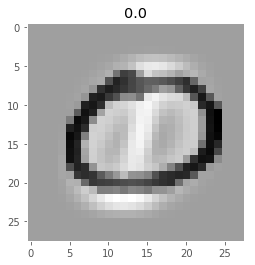

In [19]:
k = np.random.randint (len (Y_test))
plt.imshow (np.reshape (X_test [k], (28,28)), cmap = plt.cm.binary)
plt.title (Y_test [k])
plt.grid (False)
plt.show ()            

### Loading weights

We'd like to use the weights obtained by training. That is easily done by using the class load_PSBC_model().

In [20]:
L = load_PSBC_model ()

Let's get the path for some of the weights. For that, let's use the pickled dictionary All_filepath... in the Statistic folder:

In [21]:
with open ("Statistics/All_filepaths_best_weights.p", 'rb') as pickled_dic:
    All_filepaths_best_weights  = pickle.load (pickled_dic)

To retrieve the fiepaths, you use the keys as explained in the README file, or jupyter-notebook ***

In [22]:
All_filepaths_best_weights ["Classifier_196"][2][(variable_0, variable_1)][1][196][0]["best_weights"]

['Classifier_196/2/weights/0_0_196_1_0_0_fold_0_var0_0_var1_1_best_weights.h5',
 'Classifier_196/2/weights/0_0_196_1_0_0_fold_1_var0_0_var1_1_best_weights.h5',
 'Classifier_196/2/weights/0_0_196_1_0_0_fold_2_var0_0_var1_1_best_weights.h5',
 'Classifier_196/2/weights/0_0_196_1_0_0_fold_3_var0_0_var1_1_best_weights.h5',
 'Classifier_196/2/weights/0_0_196_1_0_0_fold_4_var0_0_var1_1_best_weights.h5']

Jsut one of them suffices.

In [23]:
filepath_chosen = All_filepaths_best_weights ["Classifier_196"][2][(variable_0,variable_1)][1][196][0]["best_weights"][0]

Now, to load it into the model we just call the model, the filepath using the load_PSBC_model function

In [24]:
L.load_model_with_layers (model, filepath_chosen)

If you want you can also save the weights of a psbc using the function "save_PSBC".

In [25]:
print (save_PSBC.__doc__)


    'save_PSBC' function.

    This function saves weights of a PSBC model as a file with extension ".h5".
    It can also save parameters as a pickled file (extension ".p").

    Parameters
    ----------
    model : {keras.Model},
        Model whose weights will be saved.
    parameters : {dictionary},
        Parameters of the model, to be pickled.
    weight_name : {str, "PSBC_model"}, optional,
        Name given to the h5 file containing the weights.
    parameters_name : {str, "parameters.p"}, optional,
        Name given to pickled files that contains the pickled parameters.
    
    Returns
    -------
    Nothing is returned.
    


## Checking how well the model is doing on a given set


If you want to apply the model, you need to normalize the dataset first.

In [26]:
y_pred = model.predict_zero_one (0.5 + 0.5 * X_train )

In [27]:
accuracy_score (y_pred, Y_train)

0.9856296881168575

On the test set the result is slightly worse

In [28]:
y_pred = model.predict_zero_one (0.5 + 0.5 * X_test)

In [29]:
accuracy_score (y_pred, Y_test)

0.9872340425531915

It is also quite easy to generate confusion matrices (in case you'd like to analize the results in the Neumann, Periodic, and Neumann-non-subordinate folders:

In [30]:
confusion_matrix (y_pred, Y_test)

array([[ 957,    4],
       [  23, 1131]])

## Well, but what if I want to train the model myself?

Sure. You can definitely do it too! The simplest way is expliting the keras API and simply call model.fit

In [31]:
variable_0, variable_1 = 0, 1

In [32]:
X_train, Y_train, X_test, Y_test, _  = prepare_train_test_set (variable_0, variable_1, level = 0)

In [33]:
chosen_parameters = Best_parameters ["Neumann"][4][(variable_0,variable_1)][1][784]

In [34]:
chosen_parameters

{'dt_range': array([0.2], dtype=float32),
 'eps_range': array([0.    , 0.0625, 0.125 , 0.25  , 0.5   , 1.    ], dtype=float32),
 'layer_share_range': array([1], dtype=uint16),
 'lr_P_range': array([0.1], dtype=float32),
 'lr_U_range': array([0.001], dtype=float32),
 'ptt_range': array([784], dtype=uint16)}

In [35]:
Neumann = True
Nt = 2
dt = chosen_parameters ["dt_range"][0]
lr_U = chosen_parameters ["lr_U_range"][0]
lr_P = chosen_parameters ["lr_U_range"][0]
pt_cardnlty = 784
lks = 1
Nx = 784
eps = chosen_parameters ["eps_range"][2]
subordinate = True

In [36]:
parameters = I.dictionary (Nx, eps, Nt, pt_cardnlty, lks, dt = dt, Neumann = Neumann)

lr_schedule_U =\
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr_U,
    decay_steps = 5,
    decay_rate = 0.99,
    staircase = True)

lr_schedule_P =\
    keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = lr_P,
    decay_steps = 5,
    decay_rate = 0.99,
    staircase = True)

In [37]:
model = PSBC_build_model (
    parameters,
    train_dt_U = True, 
    train_dt_P = True, 
    lr_U = lr_schedule_U,
    lr_P= lr_schedule_P, 
    subordinate = subordinate,
    loss = keras.losses.mean_squared_error,
    metrics = [classify_zero_one],
    print_summary = True)

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_4 (Zero_layer)    multiple                  1         
_________________________________________________________________
augment_layer_2 (Augment_lay multiple                  1         
_________________________________________________________________
psbc_u_and_p_2 (PSBC_U_and_P multiple                  3137      
_________________________________________________________________
final_layer_2 (Final_layer)  multiple                  0         
Total params: 3,139
Trainable params: 3,138
Non-trainable params: 1
_________________________________________________________________
None


In [38]:
EPOCHS = 3

In [39]:
history = model.fit (0.5 + 0.5 * X_train, Y_train, epochs = EPOCHS)

Epoch 1/3
Training dt_U
Training dt_P
Training dt_U
Training dt_P
396/396 [==============================] - 27s 69ms/step - dt_P : 0.5612 - ||W_U||_{infty} : 1.0000 - loss: 0.2465 - classify_zero_one: 0.9699 - ||W_P||_{infty} : 1.0082 - dt_U : 0.5700
Epoch 2/3
396/396 [==============================] - 27s 68ms/step - dt_P : 0.4453 - ||W_U||_{infty} : 1.0001 - loss: 0.2440 - classify_zero_one: 0.9805 - ||W_P||_{infty} : 1.1344 - dt_U : 0.5699
Epoch 3/3
396/396 [==============================] - 27s 69ms/step - dt_P : 0.3589 - ||W_U||_{infty} : 1.0218 - loss: 0.2441 - classify_zero_one: 0.9763 - ||W_P||_{infty} : 1.2610 - dt_U : 0.5461


The difference in computation time between the inviscid and viscous model is considerable. This was one of the main motivations for the questions we asked in Section 3 of the paper with regards to model selection and model assessment. 


Now, if you want to see the behavior of several quantities through time (by epochs), you can plot things on the history:

In [40]:
history.history.keys ()

dict_keys(['dt_P ', '||W_U||_{infty} ', 'loss', 'classify_zero_one', '||W_P||_{infty} ', 'dt_U '])

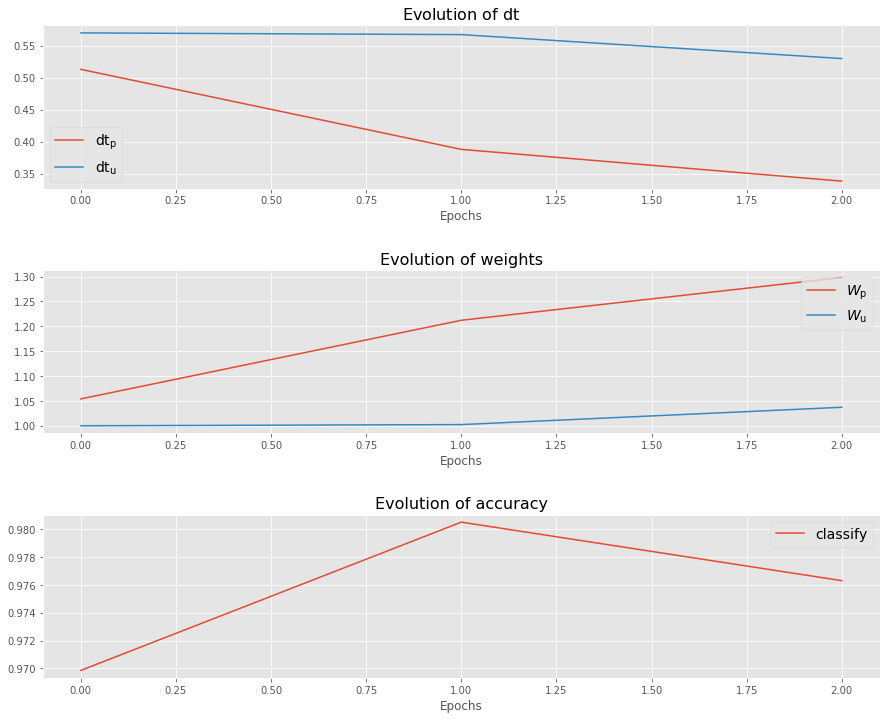

In [41]:
f, ax = plt.subplots(nrows = 3, figsize = (15,12), gridspec_kw = {'hspace' : .5})
titles = [r"Evolution of $\mathrm{dt}$", r"Evolution of weights", r"Evolution of accuracy"]

ax [0].plot (history.history ['dt_P '], label = r"$\mathrm{dt}_{\mathrm{p}}$")
ax [0].plot (history.history ['dt_U '], label = r"$\mathrm{dt}_{\mathrm{u}}$")
ax [1].plot (history.history ['||W_P||_{infty} '], label = r"$W_{\mathrm{p}}$")
ax [1].plot (history.history ['||W_U||_{infty} '], label = r"$W_{\mathrm{u}}$")
ax [2].plot (history.history ['classify_zero_one'], label = "classify")

for i, fig_now in  enumerate (zip(ax, titles)):
    ax_now, title_now = fig_now
    ax_now.set_title (title_now, size = 16)
    ax_now.grid (True)
    ax_now.set_xlabel ("Epochs")
    ax_now.legend (loc = i%2, fontsize = 14)
plt.show()

Notice that there is a peak in accuracy before the final epoch. That's one of the main reasons why Early Stopping has been adopted througout our computations.

Last, let's check the accuracy on training and test sets:

In [42]:
y_pred = model.predict_zero_one (0.5 + 0.5 * X_train)
print ("Accuracy on training set is", accuracy_score (y_pred, Y_train))

Accuracy on training set is 0.9749703908409001


In [43]:
y_pred = model.predict_zero_one(0.5 + 0.5 * X_test)
print ("Accuracy on training set is", accuracy_score (y_pred, Y_test))

Accuracy on training set is 0.9806146572104019


# Ensemble learning

Since we have 5 models, no hard voting system would end up in ties. Therefore we define a model that votes based on the averages of the 5 models we have trained.


Even though the model has been implemented in full generality, I load it with weights from the classifier, and that relies on the folder structure (to retrieve such data). With that said, we will need to descend into the folder "Classifier_196/2/"

In [44]:
os.chdir ("Classifier_196/2/")

Now we can retrieve the model

In [45]:
how_many = 5
with_PCA = False
variable_0, variable_1 = 0, 1

X_train, Y_train, X_test, Y_test,_  = prepare_train_test_set (variable_0, variable_1, level = 2)

In [46]:
model_ensemble = PSC_ensemble (
    variable_0 = variable_0, variable_1 = variable_1,
    how_many = how_many, with_PCA = with_PCA)

Number of grids 5
Loading models
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_8 (Zero_layer)    multiple                  1         
_________________________________________________________________
augment_layer_4 (Augment_lay multiple                  1         
_________________________________________________________________
psbc_u_and_p_4 (PSBC_U_and_P multiple                  784       
_________________________________________________________________
final_layer_4 (Final_layer)  multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None
Setting up a U layer with Neumann B.C.s.
Setting up a su

Predictions in this case are given as 5 votes, of which hard voting is taken. Let's make a test by picking 10 individuals at random from the training set and voting:

In [47]:
choose_people = np.random.choice (np.arange (len (Y_train)), size = 10)

In [48]:
Test = X_train [choose_people]

In [49]:
Y_train [choose_people]

array([1., 0., 0., 0., 1., 0., 1., 0., 0., 0.])

Let's see how the classifiers vote. For this model we don't need any normalization beforehand. That's because the model takes care of that for us.

In [50]:
commitee_vote = model_ensemble (Test)
commitee_vote

<tf.Variable 'psc_ensemble/Variable:0' shape=(10, 5) dtype=float32, numpy=
array([[1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>

In [51]:
hard_vote_committee = model_ensemble.hard_vote (Test)

hard_vote_committee 

array([[1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.]], dtype=float32)

In [52]:
accuracy_score (hard_vote_committee , Y_train [choose_people])

0.8

Overall, we have this

In [53]:
hard_vote_committee = model_ensemble.hard_vote (X_test)

In [54]:
accuracy_score (hard_vote_committee, Y_test)

0.742789598108747

The results are poor for a reason: the model takes care of normalization automatically. Furthermore, the function prepare train_test set balances out the data set in advance, removing the average from the test set. What we need instead are functions that are not normalized

In [55]:
S = select_split_pickle (level = 2)

X_train, Y_train, _ = S.select_variables_from_pickle (
    variable_0, variable_1, type_of = "train", averaged = False)

Let's check now:

In [56]:
y_pred = model_ensemble.hard_vote (X_train)

accuracy_score (y_pred, Y_train)

0.9865771812080537

Let's take a look at the test set

In [57]:
S = select_split_pickle (level = 2)
X_test, Y_test, _ = S.select_variables_from_pickle (
        variable_0, variable_1, type_of = "test", averaged = False)

In [58]:
y_pred = model_ensemble.hard_vote (X_test)
accuracy_score (y_pred, Y_test)

0.9881796690307328

In [59]:
os.chdir("../../")

# Multiclass classification using the PSBC

Since we are using a  one-versus-one method, we will have to load weights from several PSBCs, applied on pairs of digits of the MNIST database. As in the previous case, we rely on the folder structure (to retrieve such data). With that said, we will need to descend into the folder "Classifier_196/2/"

In [60]:
os.chdir("Classifier_196/2/")

Then, let's retrieve some elements of the MNIST database to test on.

In [61]:
mnist = fetch_openml ('mnist_784', version=1)

X, Y = mnist ["data"], mnist ["target"]

M = MinMaxScaler(feature_range=(0,1))
M.fit (X)
X_norm = M.transform (X)
X_norm_test, Y_test = X_norm [60000:,:], Y [60000:]

And now we are ready to call the classifier. Every binary classifier it calls is based on ensemple learning (it is a model given by "PSC_ensemble()", which turns out to use the weights of 5 PSBCs, due to Ensemble Learning). It is set up to print the summary of each ensemble model it relies on. In other words, it prints a long summary.

In [62]:
classifier_multiclass = PSBC_multi_class ()

Loading models
Number of grids 5
Loading models
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_18 (Zero_layer)   multiple                  1         
_________________________________________________________________
augment_layer_9 (Augment_lay multiple                  1         
_________________________________________________________________
psbc_u_and_p_9 (PSBC_U_and_P multiple                  784       
_________________________________________________________________
final_layer_9 (Final_layer)  multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None
Setting up a U layer with Neumann B.C.s.


Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Number of grids 5
Loading models
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_88 (Zero_layer)   multiple                  1         
_________________________________________________________________
augment_layer_44 (Augment_la multiple                  1         
_________________________________________________________________
psbc_u_and_p_44 (PSBC_U_and_ multiple                  784       
_________________________________________________________________
final_layer_44 (Final_layer) multiple                  0         
Total params: 786
Traina

Model: "psbc_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_148 (Zero_layer)  multiple                  1         
_________________________________________________________________
augment_layer_74 (Augment_la multiple                  1         
_________________________________________________________________
psbc_u_and_p_74 (PSBC_U_and_ multiple                  784       
_________________________________________________________________
final_layer_74 (Final_layer) multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Numbe

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Number of grids 5
Loading models
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_218 (Zero_layer)  multiple                  1         
_________________________________________________________________
augment_layer_109 (Augment_l multiple                  1         
_________________________________________________________________
psbc_u_and_p_109 (PSBC_U_and multiple                  784       
_________________________________________________________________
final_layer_109 (Final_layer multiple                  0         
Total params: 786
Train

Model: "psbc_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_278 (Zero_layer)  multiple                  1         
_________________________________________________________________
augment_layer_139 (Augment_l multiple                  1         
_________________________________________________________________
psbc_u_and_p_139 (PSBC_U_and multiple                  784       
_________________________________________________________________
final_layer_139 (Final_layer multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Numb

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Number of grids 5
Loading models
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_348 (Zero_layer)  multiple                  1         
_________________________________________________________________
augment_layer_174 (Augment_l multiple                  1         
_________________________________________________________________
psbc_u_and_p_174 (PSBC_U_and multiple                  784       
_________________________________________________________________
final_layer_174 (Final_layer multiple                  0         
Total params: 786
Train

Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Model: "psbc_204"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_layer_408 (Zero_layer)  multiple                  1         
_________________________________________________________________
augment_layer_204 (Augment_l multiple                  1         
_________________________________________________________________
psbc_u_and_p_204 (PSBC_U_and multiple                  784       
_________________________________________________________________
final_layer_204 (Final_layer multiple                  0         
Total params: 786
Trainable params: 786
Non-trainable params: 0
_________________________________________________________________
None
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Setting up a U layer with Neumann B.C.s.
Setting up a subordinate model with phase
Sett

Since this step requires a lot of memory, I will only carry out a the example for a few individuals:

In [63]:
X_small_test, Y_small_test = X_norm_test [:13], Y_test [:13]

Now we are ready to start. 

If you propagate individuals using this model you will get a 10 times 10 matrix in the last layer. This is a matrix of votes, telling which digit "win" in each pairwise classification the individual is tested on.

In [64]:
y_pred = classifier_multiclass (np.asarray (X_small_test, dtype = np.float32))

Let's see what it looks like

In [65]:
y_pred.shape

TensorShape([13, 10, 10])

In [66]:
y_pred [1]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 0., 0., 1., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 1., 0., 0., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)>

The meaning of this matrix is clear: if you look at the element i,j (that is, row i, column j, numbering the first one in each of them as 0) we are talking about the result predicted when classifying the individual X_small_test [1] using the PSBC trained on digits i and j. 

Let's call this matrix as M. For instance: when i = 0, j = 3, the aggregated PSBC assignes a 0 to that entry. Consequently, element (3,0) is a 1 (check!). It means that it casts a vote on "3" rather than on "0". Evidently, no votes are cast on the diagonal (which contains only zeros), for the model never performs binary classification over the same two classes.

Now, if one want to compute the total number of votes each class receives one just needs to sum up over rows. Let's do that for all these individuals.

In [67]:
tf.reduce_sum (y_pred, axis = -1)

<tf.Tensor: shape=(13, 10), dtype=float32, numpy=
array([[0., 5., 2., 3., 7., 6., 1., 9., 4., 8.],
       [4., 3., 9., 7., 2., 8., 6., 0., 5., 1.],
       [0., 9., 6., 4., 1., 8., 2., 6., 6., 3.],
       [9., 0., 5., 6., 1., 6., 8., 4., 3., 3.],
       [0., 1., 5., 2., 9., 4., 6., 7., 3., 8.],
       [0., 9., 3., 5., 2., 7., 1., 6., 8., 4.],
       [0., 3., 2., 4., 9., 7., 1., 7., 5., 7.],
       [0., 3., 1., 2., 8., 7., 4., 6., 5., 9.],
       [6., 1., 6., 1., 8., 6., 8., 1., 4., 4.],
       [1., 1., 1., 3., 7., 5., 4., 9., 6., 8.],
       [9., 0., 6., 6., 3., 8., 4., 2., 6., 1.],
       [1., 1., 8., 4., 6., 5., 9., 1., 7., 3.],
       [0., 3., 1., 3., 7., 6., 3., 8., 5., 9.]], dtype=float32)>

A nice way to check whether we summed up over the correct axis is noticing that the symmetry in the output matrix forces it to contain a total of 45 "1"s. Let's sum up each row again:

In [68]:
the_election_was_not_stolen = tf.reduce_sum (tf.reduce_sum (y_pred, axis = -1), axis = -1)

In [69]:
the_election_was_not_stolen

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45., 45.],
      dtype=float32)>

Great!

Now, evidently, if we use hard votes, we just assign the individual to the class that has the highest number of votes. We are doomed to have problems with that if we do not figure out how to solve ties. A possible approach is that of obtaining the most voted individuals and then randomly selecting one among them. Note that this applyies to all cases, even when a single winner is obtained: it ends up being selected by this same algorithm with probability 1.

To make this long story short, this is what the function tournament does. 

In [70]:
T = tournament (hardvote_or_tournament = "hard_vote")

And class assignment is obtained by doing

In [71]:
T.aux_tournament (y_pred)

array([7., 2., 1., 0., 4., 1., 4., 9., 4., 7., 0., 6., 9.])

In fact, it does it in two possible ways: hard voting or tournaments, in which case the 10 individuals are voted, those with lowest votes are removed, and then a new tournaments is defined, only with the votes of the remanescent classes. The previous step repeats until a tie is obtained, and the winner is selected randomly. Of course, the same remarks about a single winner hold in this case as well. 

You can test it by changing the above code to
>**hardvote_or_tournament = "tournament"** 

(you will probably have to define y_pred again before that, for both functions make changes to the prediction vector as a way to save some memory).

# Final remarks

If you are interested in computational details, you should read the code on github. There are about 4-5 thousand lines of code, but I'm honest in saying that things are well organized.  *(The README.pdf file on Github may help you too!)*

<br>    By and large I tried to split most models into several layers that have been implemented separately. Functions and classes - as well as their methods -  are quite short: this is done because compartmentalization accelerates implementation, debugging, and fixing (especially when things go wrong, as they always go). For example: implementing the layers took me about of 1 week  this time, whereas in numpy it took me almost a month. This is the first time I used management and software engineering techniques (Scrum and Toyota style) in a scientific project, and I strongly recommend people to learn more about them (especially scientists).

<br>For mathematical details, I recommend the paper. It is short and most of the Mathematics is simple and does not rely on heavy machinery.    


<br>I should remark that the implementation path I followed, based on tensorflow/keras, is a bit unusual, because it treats the variation of parameters dt_u and dt_p as **"bifurcation parameters"**. Although neither of these APIs directly support this type of architecture, they can be achieved if you change the perspective to that of a Recursive Neural Network. I make short statements about that towards the end of the paper, but I didn't want to bother the reader with this matter. 


<br> Last, remarks about wavelets, gradient flows, mean field models,  and other were put aside for the sake of keeping the paper short and self contained. I have some ideas of where research on this model can go, some of which I shared in the paper (mostly in Section 4). 


<br>That's it for now. Please, do not hesitate to contact me if you have any questions or would like further clarifications. 
<br>
<br> 

**Rafael Monteiro, Sendai/Japan, September 18, 2021.**